# HyperParameter Optimization in Machine Learning

Today, We will be talking about hyperparameters and algorithms which can help us optimize the hyperparameters. The first question which comes to the mind is “How a hyperparameter is different from a parameter?”. Hyperparameters are values that you fix before the learning process starts and they are not changed by the learning process. A few good examples would be batch_size, layer size, the number of layers, learning_rate in the neural nets or regularization weight in the lasso regression.

The next question which pops in mind is “Why hyperparameters need to be optimized?”. The goal of the learning process is to reduce the error on the new data. By tuning the hyperparameters to the optimal values we can get a model that minimizes the error better than any other model having the same learning algorithm. Some algorithms have many hyperparameters and some none. For example, ODE(Ordinary Least Squares) has no hyperparameters while random forest has n_estimators, learning rate, subsample as hyperparameters. Also, different hyperparameters have different effects on the fitting of a model. For example, increasing the learning rate in xgboost makes learning harder & slow and increases chances of overfitting while high values of lambda and alpha which are regularization weights reduce overfitting.

Now comes the part “How do we tune hyperparameters?”. There are different ways to tune hyperparameters like manual tuning(trial & error), grid search, randomized search, evolutionary algorithm e.t.c. We will talk about some of these hyperparameter tuning algorithms and the libraries which implement them. Before we dive into these algorithms and libs we need to choose models(whose hyperparameters are to be optimized), a dataset(for fitting the models) and a cross-validation strategy. We will be using the wine quality dataset and Random Forest & XGBoost as models. Cross-validation is a process to check the trained model’s accuracy on unseen data. We will be using K-Fold cross-validation strategy. In the K-Fold method, a dataset is divided into K parts. Then, we loop over the K parts using ith fold as a test data and train model over the rest of the folds. The accuracy of the model is average accuracy over all the iterations. Let’s read the data and do a bit of cleaning if required. Fire up a bash terminal and run the following commands to download the dataset and install the required libraries.

In [1]:
!mkdir hyperparameter-tuning
!cd hyperparameter-tuning
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv
!pip3 install hyperopt scikit-optimize optunity dlib

  Using cached https://files.pythonhosted.org/packages/0b/4a/79541d4f61e7878f846f68ab31ed709bac6ee99345378c0e02658c3be0d4/hyperopt-0.2.2-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/f4/44/60f82c97d1caa98752c7da2c1681cab5c7a390a0fdd3a55fac672b321cac/scikit_optimize-0.5.2-py2.py3-none-any.whl
Processing /home/pauli/.cache/pip/wheels/c9/e2/80/d3794524ae0042e147e035e132ec5fac09b8794b4acd94f046/Optunity-1.1.1-cp36-none-any.whl
Processing /home/pauli/.cache/pip/wheels/96/ac/11/8aadec62cb4fb5b264a9b1b042caf415de9a75f5e165d79a51/dlib-19.19.0-cp36-cp36m-linux_x86_64.whl
Processing /home/pauli/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e/future-0.18.2-cp36-none-any.whl
  Using cached https://files.pythonhosted.org/packages/c1/49/334e279caa3231255725c8e860fa93e72083567625573421db8875846c14/cloudpickle-1.2.2-py2.py3-none-any.whl
Processing /home/pauli/.cache/pip/wheels/68/f8/29/b53346a112a07d30a5a84d53f19aeadaa1a474897c0423af91/networkx-2

Let’s have a look at the data.

In [2]:
import pandas as pd
import numpy as np

wine = pd.read_csv('winequality-white.csv', sep=";")
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


Now, we need to divide our dataset into three folds. At every ith iteration, we need to use the ith fold as a test and combine the two others for training. Luckily, sklearn provides a function StratifiedShuffleSplit for that. The use of stratifying is to preserve the distribution of target classes in all the three folds as closely as possible.

In [3]:
from sklearn import model_selection as ms
X =  wine.drop('quality', axis=1)
y = wine['quality']
splitter = ms.StratifiedShuffleSplit(n_splits = 5, test_size = 0.3, random_state = 0 )

inds = []  
for tr_ind, val_ind in splitter.split(X,y):  
    inds.append([tr_ind, val_ind])

Next, we need to create a function which iterates over these folds and calculates the average loss across all the folds. We will use logloss for measuring the accuracy of a model.

In [4]:
from sklearn import metrics
from sklearn import ensemble
import xgboost as xgb

num_iter = 1000 
errors = []
log_loss = metrics.log_loss

def error(model, X, Y): 
    test_preds = model.predict_proba(X) 
    return(log_loss(Y, test_preds))

def validate_model(model, trX, trY, valX, valY):

    model.fit(trX, trY)
    val_err = error(model, valX, valY)
    tr_err = error(model, trX, trY)
    #print('train error {tr_err}  ||||  test error {err}'.format(err = val_err, tr_err=tr_err))
    return(val_err)


def cross_validate_rf(n_estimators, max_depth, max_features, min_samples_leaf):

    total_err = 0.0
    #print(N_estimators, max_depth, max_features, min_samples_leaf)
    model = ensemble.RandomForestClassifier(n_estimators = int(n_estimators), max_depth = 
                                        int(max_depth), max_features = max_features,
                                        min_samples_leaf = min_samples_leaf)

    for tr_ind, val_ind in inds:

        total_err+= validate_model(model, X.iloc[tr_ind].values, y.iloc[tr_ind].values,
                               X.iloc[val_ind].values, y.iloc[val_ind].values)

        #print('err = {err}\n'.format(err = total_err/3))
    errors.append(total_err/len(inds))
    return(total_err/len(inds))


def cross_validate_xgb(n_estimators, learning_rate, max_depth, min_child_weight, subsample, gamma, colsample_bytree):

    total_err = 0.0
    #print(N_estimators, max_depth, max_features, min_samples_leaf)
    model = xgb.XGBClassifier(n_estimators = int(n_estimators), max_depth = int(max_depth), 
                              learning_rate = learning_rate, min_child_weight = min_child_weight,
                              subsample = subsample, gamma = gamma, colsample_bytree = colsample_bytree)
    for tr_ind, val_ind in inds:
        total_err+= validate_model(model, X.iloc[tr_ind].values, y.iloc[tr_ind].values,
                               X.iloc[val_ind].values, y.iloc[val_ind].values)
    errors.append(total_err/len(inds))
    return(total_err/len(inds))

## Randomized Search

We will start with Randomized Search algorithm.
In a Randomized search, a new candidate is drawn randomly from the hyperparameter distribution a fixed number of times irrespective of the history of the previously evaluated points. Randomized works better than the grid and manual tuning because not all parameters equally affect the loss function. Unlike GridSearch, RandomizedSearch can be stopped and restarted without any fuss.

Hyperopt: We will be using hyperopt lib’s randomized search algorithm. The salient feature of hyperopt is that it supports many types of parameter search spaces including categorical. For example, If a parameter ‘type’ takes values [‘A’, ‘B’, ‘C’] then you can set up a search space like this ‘hp.choice(‘type’, [‘A’, ‘B’, ‘C’])’. Also, If you wish to return more than the error something like how much time is used by the model to run or whether the model has successfully run or not you can use Trials object. Hyperopt supports both synchronous and parallel operations The interaction point is the fmin function which takes 4 arguments: i) a function to optimize, ii) a search space iii) the maximum number of evaluations to run, and iv) an optional Trial object to return something else than error. Let’s create the parameter search space of both RandomForest and XGBoost models and implement the search function.

In [5]:
from hyperopt import fmin, hp, tpe
import hyperopt
# we have to define parameter search space like this.

rf_space = { 'n_estimators': hp.uniform('n_estimators', 20,200), 'max_depth': hp.uniform('max_depth', 2,10), 'max_features': hp.uniform('max_features', 0.2, 0.7), 'min_samples_leaf': hp.uniform('min_samples_leaf', 0.01, 0.5)

}

xgb_space ={ 'max_depth': hp.uniform('max_depth', 1,15), 'min_child_weight': hp.quniform ('min_child', 1, 20, 1), 
            'subsample': hp.uniform ('subsample', 0.8, 1), 'n_estimators' : hp.uniform('n_estimators', 20, 200), 
            'learning_rate' : hp.quniform('learning_rate', 0.025, 0.5, 0.025), 
            'gamma' : hp.quniform('gamma', 0.5,1, 0.05), 
            'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05) }

# Search function

def hyperopt_tune_rf(params): 
    return(cross_validate_rf(params['n_estimators'], params['max_depth'], params['max_features'], 
                             params['min_samples_leaf']))

def hyperopt_tune_xgb(params): 
    return(cross_validate_xgb(params['n_estimators'], params['learning_rate'], params['max_depth'], 
                              params['min_child_weight'], params['subsample'], params['gamma'], 
                              params['colsample_bytree']))

errors = [] 
rnd_best_rf = fmin(fn = hyperopt_tune_rf, space = rf_space, algo = hyperopt.rand.suggest, max_evals = 250) 
rnd_rf_errors = errors

errors = [] 
rnd_best_xgb = fmin(fn = hyperopt_tune_xgb, space = xgb_space, algo = hyperopt.rand.suggest, max_evals = 250) 
rnd_xgb_errors = errors

print('best_rf_params = {best_rf_params}'.format(best_rf_params = rnd_best_rf))
print('best_xgb_params = {best_xgb_params}'.format(best_xgb_params = rnd_best_xgb))

100%|██████████| 250/250 [20:42<00:00,  4.97s/it, best loss: 0.8785131286931079]
best_rf_params = {'max_depth': 5.949054898570386, 'max_features': 0.44318844386562095, 'min_samples_leaf': 0.01054890111366292, 'n_estimators': 114.63840558911996}
best_xgb_params = {'colsample_bytree': 0.7000000000000001, 'gamma': 0.75, 'learning_rate': 0.1, 'max_depth': 9.946415492105874, 'min_child': 4.0, 'n_estimators': 177.5256148422791, 'subsample': 0.8507659189247382}


In [6]:
import pickle
with open("rand_errs.pkl","wb") as f:
    pickle.dump( [rnd_rf_errors, rnd_xgb_errors], f)

Let’s see the line graph of losses from both the model.

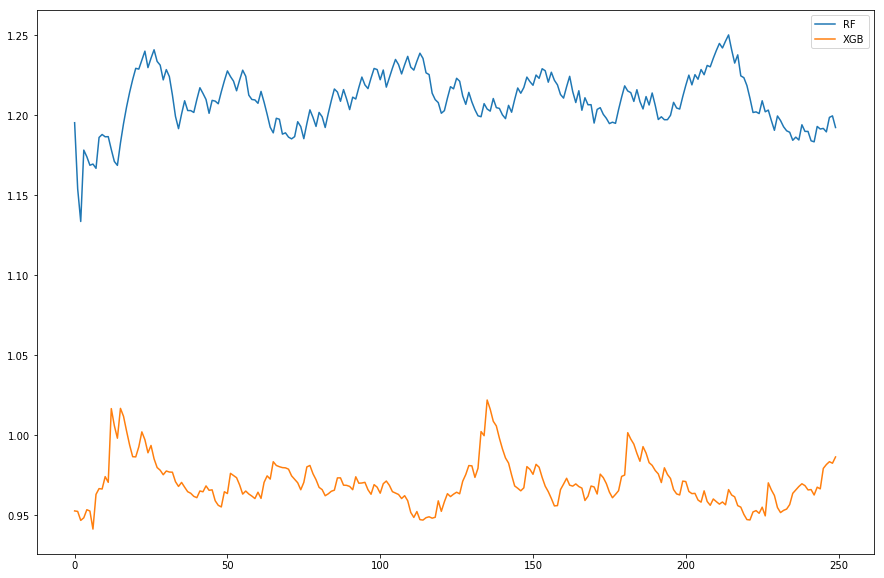

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
# exponential smoothing is used to tone down the oscillations of the loss
plt.figure(figsize=(15,10))
#plt.ylim(2.75,3.75)
for series in [rnd_rf_errors, rnd_xgb_errors]:
    plt.plot(pd.Series( series).ewm(com=10).mean())
plt.legend( ['RF', 'XGB'])

## Tree-Structured Parzen Estimators(TPE)

Our next algorithm will be Tree-Structured Parzen Estimators.
It a sequential model-based optimization(SMBO) process i.e. it tries to estimate the expected improvement in the loss with a model. Initially, a randomized search algorithm is run for a fixed number of iterations. Then, these points are divided into two groups, best 10-20% as good ones while the rest as the bad ones. At the next iteration, a fixed number of solutions are drawn from the parameter space. Every solution’s expected improvement is measured by the ratio of the probability of being the good one to the probability of being the bad one. Then, the solution with highest expected improvement is tried. The parameter space is divided in form of tree structures. Again, we will use the hyperopt library. Everything will be same as above except algo which is now tpe.suggest.

In [9]:
# run optimization algo for tuning params
errors = []
tpe_best_rf = fmin(fn = hyperopt_tune_rf, space = rf_space, algo = tpe.suggest, max_evals = 250)
tpe_rf_errors = errors

errors = []
tpe_best_xgb = fmin(fn = hyperopt_tune_xgb, space = xgb_space, algo = tpe.suggest, max_evals = 250)
tpe_xgb_errors = errors

print('tpe_rf_params = {tpe_rf_params}'.format(tpe_rf_params = tpe_best_rf))
print('tpe_xgb_params = {tpe_xgb_params}'.format(tpe_xgb_params = tpe_best_xgb))

100%|██████████| 250/250 [35:36<00:00,  8.55s/it, best loss: 0.844380599839144] 
tpe_rf_params = {'max_depth': 9.368092368796518, 'max_features': 0.5351273450397012, 'min_samples_leaf': 0.010898510301322143, 'n_estimators': 132.01166433959312}
tpe_xgb_params = {'colsample_bytree': 0.65, 'gamma': 0.65, 'learning_rate': 0.07500000000000001, 'max_depth': 13.44685560193331, 'min_child': 1.0, 'n_estimators': 135.51218526019082, 'subsample': 0.8747996063079335}


In [10]:
import pickle
with open("tpe_errs.pkl","wb") as f:
    pickle.dump( [tpe_rf_errors, tpe_xgb_errors], f)

In [ ]:
Let’s visualize the line graph of losses.

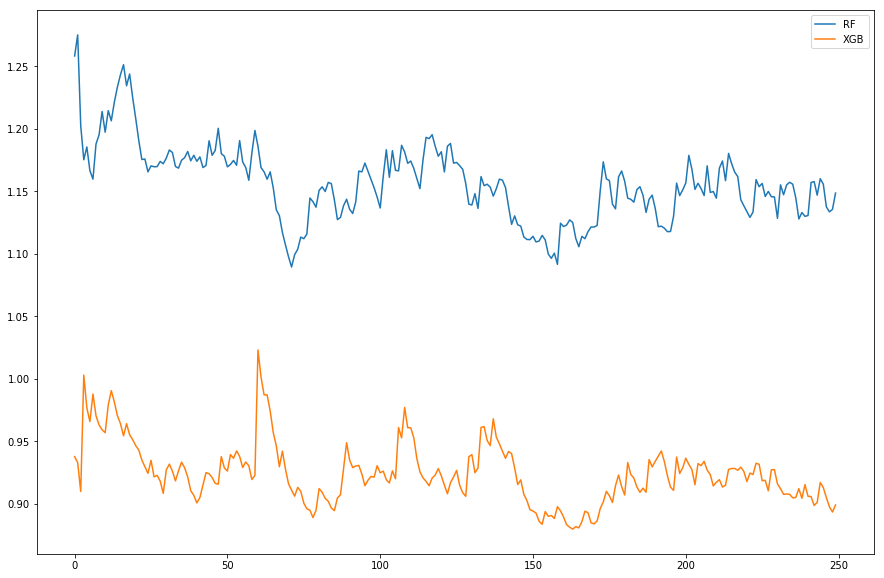

In [11]:
# exponential smoothing is used to tone down the oscillations of the loss
plt.figure(figsize=(15,10))
#plt.ylim(2.75,3.75)
for series in [tpe_rf_errors, tpe_xgb_errors]:
    plt.plot(pd.Series( series).ewm(com=5).mean())
plt.legend( ['RF', 'XGB'])

## Bayesian Optimization using Gaussian Process

Next, in line is Bayesian optimization method using Gaussian Processes.
It is a very popular method. When the evaluation of the function is expensive and slow, the function is approximated via a multivariate Gaussian process based on all evaluated points. An acquisition function is chosen which generates a new solution at every iteration by balancing exploitation and exploration. Examples of acquisition functions are Probability of Improvement(PI), Expected Improvement(EI). Using the fitted Gaussian process, a new candidate’s expected improvement is calculated and the candidate with the highest expected improvement is chosen for the next trial. Libraries like spearmint, scikit-optimize provide the implementation of these algorithms. We will use scikit-optimize for our purpose.

Scikit-Optimize: Like hyperopt, scikit-opt also accepts categorical values as parameters. It supports several methods based on sequential model-based optimization including Bayesian optimization using Gaussian processes, sequential optimization using both decision trees and boosted trees. Scikit-opt provides a function gp_minimize which implements the above method. The important parameters of gp_minimize are i) function to minimize, ii) search space, iii) acquisition function, iv) max number of calls.

In [38]:
from skopt.space import Real, Integer
from skopt.utils import use_named_args

# create the search space
skopt_rf_space = [
     Integer(20, 200, name = 'n_estimators'),
    Integer(1, 10, name = 'max_depth'),
    Real(0.2, 0.7, name = 'max_features'),
    Real(0.01, 0.5, name = 'min_samples_leaf')

]

skopt_xgb_space =[
        Integer(1, 15, name = 'max_depth'),
        Integer(1, 20, name = 'min_child_weight'),
        Real(0.8, 1, name = 'subsample'),
        Integer(20, 200, name = 'n_estimators'),
        Real(0.025, 0.5, name = 'learning_rate'),
        Real(0.5, 1, name = 'gamma'),
        Real(0.5, 1, name = 'colsample_bytree')
    ]
#by using use_named_args we can supply parameters dicts to the function

@use_named_args(skopt_rf_space)
def skopt_tune_rf(**params):

    return(cross_validate_rf(params['n_estimators'], params['max_depth'], params['max_features']
                         , params['min_samples_leaf']))

@use_named_args(skopt_xgb_space)
def skopt_tune_xgb(**params):

    return(cross_validate_xgb(params['n_estimators'], params['learning_rate'], params['max_depth'],
                             params['min_child_weight'], params['subsample'], params['gamma'],
                             params['colsample_bytree']))

from skopt import gp_minimize
errors = []
gp_best_rf = gp_minimize(skopt_tune_rf, skopt_rf_space, n_calls=250, random_state=0)
gp_rf_errors = errors

errors = []
gp_best_xgb = gp_minimize(skopt_tune_xgb, skopt_xgb_space, n_calls = 250, random_state=0)
gp_xgb_errors = errors


rf_params = { key:value for value, key in zip(gp_best_rf['x'],['n_estimators', 'max_depth', 'max_features', 'min_samples_leaf'])}
xgb_params = {key:value for value, key in zip(gp_best_xgb['x'], ['max_depth', 'min_child_weight', 'subsample', 'n_estimators', 'learning_rate', 
                       'gamma', 'colsample_bytree'])}

print('gp_rf_params = {gp_rf_params}'.format(gp_rf_params = rf_params))
print('gp_xgb_params = {gp_xgb_params}'.format(gp_xgb_params = xgb_params))

gp_rf_params = {'n_estimators': 200, 'max_depth': 10, 'max_features': 0.7, 'min_samples_leaf': 0.01}
gp_xgb_params = {'max_depth': 15, 'min_child_weight': 1, 'subsample': 1.0, 'n_estimators': 191, 'learning_rate': 0.04967305875282799, 'gamma': 0.5, 'colsample_bytree': 0.5}


Let’s check the plots of losses in both models.

In [13]:
import pickle
with open("gp_errs.pkl","wb") as f:
    pickle.dump( [gp_rf_errors, gp_xgb_errors], f)

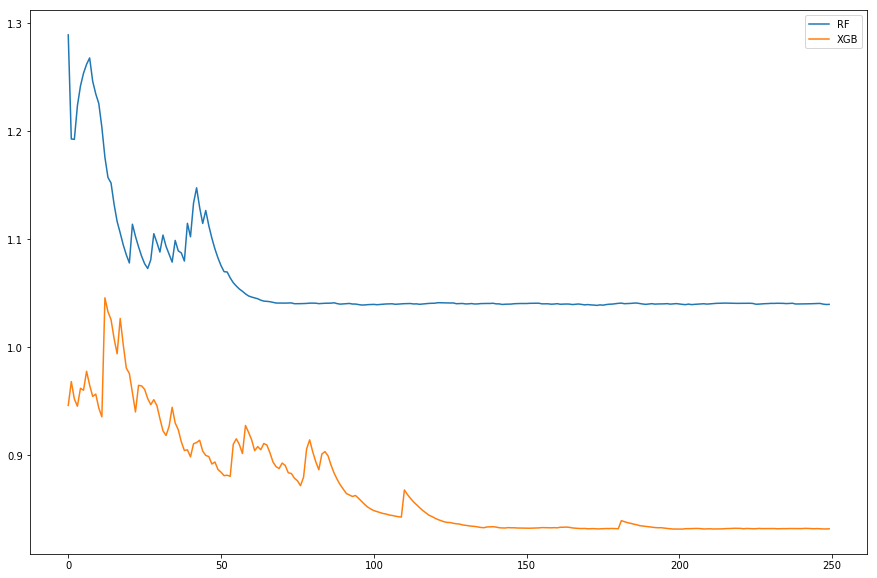

In [14]:
# exponential smoothing is used to tone down the oscillations of the loss
plt.figure(figsize=(15,10))
#plt.ylim(2.75,3.75)
for series in [gp_rf_errors, gp_xgb_errors]:
    plt.plot(pd.Series( series).ewm(com=5).mean())
plt.legend( ['RF', 'XGB'])

## Particle Swarm Optimization

Now, we will go to Particle Swarm Optimization which is based on swarm intelligence.
PSO is a type of heuristic algorithm based on the social behavior of a group of particles(birds, fish). At the initialization, a fixed number of particles(solutions) are generated randomly. At each iteration, a new position for each particle is generated by taking into account the best position in both global and local search space. For exploration, the global best position is given more weight while in case of exploitation the local best position is more preferred. If the number of particles is large the solution will gravitate towards a randomized search. The important parameters for the PSO algorithm are i) number of particles, ii) the number of generations, iii) weight of local best position, iv) weight of global best position, v) upper bound on how far can be the next position from the current position. We will use Optunity for this purpose.

Optunity: Optunity library supports different approaches and methods like particle swarm optimization(PSO), GridSearchCV, Simplex. It has support for scikit-learn. We will be using  Optunity’s PSO algorithm for hyperparameter optimization. Let’s write the search space an function. We need to remember that solutions generated might be out of bounds. Hence, we need to implement a function to check bounds before the evaluation.



In [28]:

pso_rf_space = {
    'n_estimators': [ 20,200],
    'max_depth': [2,10],
    'max_features': [0.2, 0.7],
    'min_samples_leaf': [ 0.01, 0.5]

}

pso_xgb_space ={
        'max_depth': [ 1,15],
        'min_child_weight': [1, 20],
        'subsample': [ 0.8, 1],
        'n_estimators' : [ 20, 200],
        'learning_rate' : [0.025, 0.5],
        'gamma' : [ 0.5, 1],
        'colsample_bytree' : [ 0.5, 1]
}

def check_bounds_rf(param, val):

    if val > pso_rf_space[param][1]:
        return(pso_rf_space[param][1])
    elif val < pso_rf_space[param][0]:
        return(pso_rf_space[param][0])
    else:
        return(val)


def check_bounds_xgb(param, val):

    if val > pso_xgb_space[param][1]:
        return(pso_xgb_space[param][1])
    elif val < pso_xgb_space[param][0]:
        return(pso_xgb_space[param][0])
    else:
        return(val)


def pso_tune_rf(**params):

    for param in params:
        params[param] = check_bounds_rf(param, params[param])

    return(cross_validate_rf(params['n_estimators'], params['max_depth'], params['max_features']
                         , params['min_samples_leaf']))

def pso_tune_xgb(**params):

    for param in params:
        params[param] = check_bounds_xgb(param, params[param])
    return(cross_validate_xgb(params['n_estimators'], params['learning_rate'], params['max_depth'],
                             params['min_child_weight'], params['subsample'], params['gamma'],
                             params['colsample_bytree']))


import optunity as opt
errors = []
pso_best_rf = opt.minimize_structured(pso_tune_rf, pso_rf_space, num_evals= 250)
pso_rf_errors = errors

errors=[]
pso_best_xgb = opt.minimize_structured(pso_tune_xgb, pso_xgb_space, num_evals= 250)
pso_xgb_errors = errors

print('pso_rf_params = {pso_rf_params}'.format(pso_rf_params = pso_best_rf[0]))
print('pso_xgb_params = {pso_xgb_params}'.format(pso_xgb_params = pso_best_xgb[0]))

pso_rf_params = {'max_depth': 6.015533202520053, 'max_features': 0.552143020860689, 'min_samples_leaf': 0.010502979783712143, 'n_estimators': 161.0643561167537}
pso_xgb_params = {'colsample_bytree': 0.8496719873597581, 'gamma': 0.7449474083122629, 'learning_rate': 0.043736666165865336, 'max_depth': 12.906232117754918, 'min_child_weight': 1.415482271634616, 'n_estimators': 170.4991603926154, 'subsample': 0.894259314903846}


Let’s check the plots of losses in both models.

In [17]:
import pickle
with open("pso_errs.pkl","wb") as f:
    pickle.dump( [pso_rf_errors, pso_xgb_errors], f)

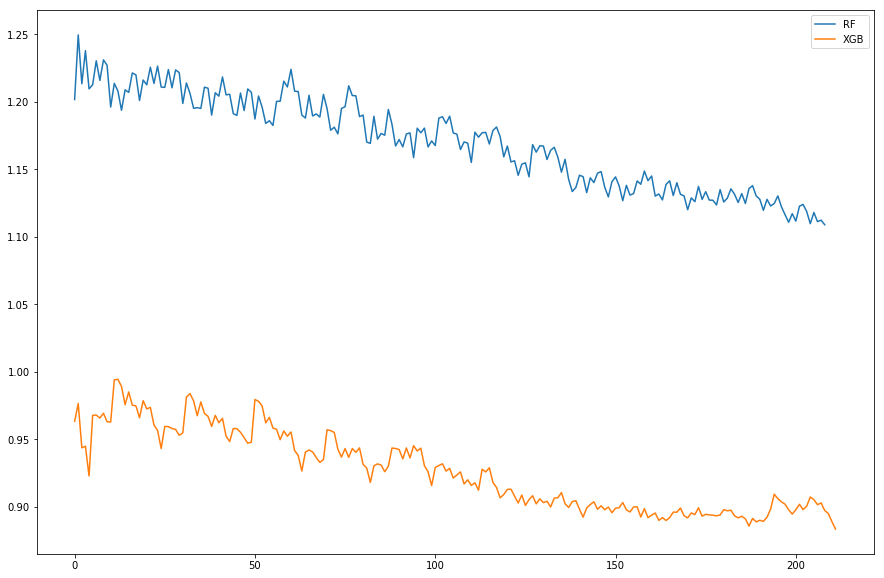

In [18]:
# exponential smoothing is used to tone down the oscillations of the loss
plt.figure(figsize=(15,10))
#plt.ylim(2.75,3.75)
for series in [pso_rf_errors, pso_xgb_errors]:
    plt.plot(pd.Series( series).ewm(com=5).mean())
plt.legend( ['RF', 'XGB'])

## LIPO

Next, we will talk about LIPO algorithm.
LIPO is a new global optimization method that uses a property of Lipshitz functions to maintain an upper bound on the function. At every iteration, a new solution is randomly drawn from the parameter space and then the function is evaluated if and only if it’s upper bound is better than the current upper bound. It does not have any parameters other than the number of iterations to run. It is important to understand that it will not work reliably if the function is noisy and discontinuous. We will use Dlib library for this method.

Dlib: Dlib is a c++ machine learning and optimization library. It has python support. We will be using an enhanced version of LIPO which is called maxLIPO+TR. Although, the LIPO method is good for getting a global solution it fails to converge the global solution to it’s local best. The Trust-Region(TR) method is added to overcome this shortcoming. The parameter search space is just a list of upper and lower bounds.

In [19]:

import dlib


def dlib_tune_rf():

    # create a list for lower & upper bound of hyperparameters 
    lb = [20, 2, 0.2, 0.01]
    ub = [200, 10, 0.7, 0.5]

    params = dlib.find_min_global(cross_validate_rf, bound1=lb, bound2 = ub,num_function_calls= 250,
                                  is_integer_variable=[1,1,0,0])
    return(params)



def dlib_tune_xgb():

    # create a list for lower and upper bound of hyper parameters
    lb = [20, 0.025, 1, 1, 0.8, 0.5, 0.5]
    ub = [200, 0.5, 15, 20, 1, 1, 1]

    params = dlib.find_min_global(cross_validate_xgb, bound1 = lb, bound2= ub, num_function_calls = 250,
                                  is_integer_variable= [1,0,1,1,0,0,0])

    return(params)
errors = []
dlib_best_rf = dlib_tune_rf()
dlib_rf_errors = errors

errors=[]
dlib_best_xgb = dlib_tune_xgb()
dlib_xgb_errors = errors

print('dlib_rf_params = {dlib_rf_params}'.format(dlib_rf_params = dlib_best_rf))
print('dlib_xgb_params = {dlib_xgb_params}'.format(dlib_xgb_params = dlib_best_xgb))

dlib_rf_params = ([152.0, 10.0, 0.7, 0.01], 1.0375910935068287)
dlib_xgb_params = ([145.0, 0.05252166091716529, 14.0, 1.0, 0.8118187683795108, 0.5066364778732485, 0.8695741682971173], 0.8430594852366516)


Let’s check the plots of losses in both models.

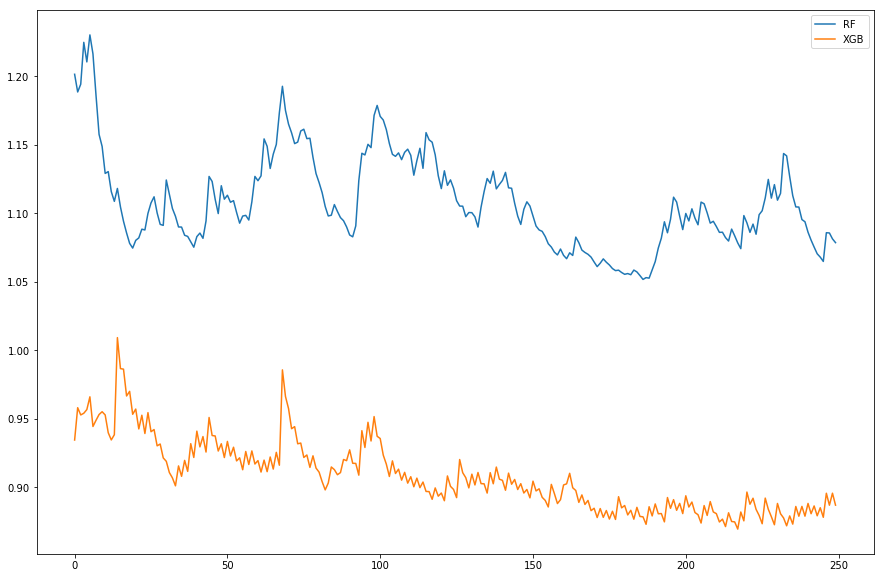

In [20]:
# exponential smoothing is used to tone down the oscillations of the loss
plt.figure(figsize=(15,10))
#plt.ylim(2.75,3.75)
for series in [dlib_rf_errors, dlib_xgb_errors]:
    plt.plot(pd.Series( series).ewm(com=5).mean())
plt.legend( ['RF', 'XGB'])

In [21]:
import pickle
with open("dlib_errs.pkl","wb") as f:
    pickle.dump( [dlib_rf_errors, dlib_xgb_errors], f)

In [36]:
min(dlib_rf_errors)

0.10340509156277115

In [24]:
rf_min_errors = {'random': min(rnd_rf_errors),
                 'tpe': min(tpe_rf_errors),
                 'gp': min(gp_rf_errors),
                 'pso': min(pso_rf_errors),
                 'lipo': min(dlib_rf_errors)
                }

xgb_min_errors = {'random': min(rnd_xgb_errors),
                 'tpe': min(tpe_xgb_errors),
                 'gp': min(gp_xgb_errors),
                 'pso': min(pso_xgb_errors),
                 'lipo': min(dlib_xgb_errors)
                }
print(rf_min_errors)
print(xgb_min_errors)

{'random': 1.0712560914510203, 'tpe': 1.0428406209558434, 'gp': 1.0363868965647514, 'pso': 1.055444929518537, 'lipo': 1.0375910935068287}
{'random': 0.8785131286931079, 'tpe': 0.844380599839144, 'gp': 0.8301285868708271, 'pso': 0.8548497588917309, 'lipo': 0.8430594852366516}


We see that "Bayesian optimization using gaussian process" has performed better than all other methods in both rf and xgb.